In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
import csv
from google.colab import files

uploaded_files = files.upload()
#create the dataframe
dfs = []
#read files


Saving market_history_monthly_2007.csv to market_history_monthly_2007 (3).csv
Saving market_history_monthly_2008.csv to market_history_monthly_2008 (3).csv
Saving market_history_monthly_2009.csv to market_history_monthly_2009 (3).csv
Saving market_history_monthly_2010.csv to market_history_monthly_2010 (3).csv
Saving market_history_monthly_2011.csv to market_history_monthly_2011 (3).csv
Saving market_history_monthly_2012.csv to market_history_monthly_2012 (3).csv
Saving market_history_monthly_2013.csv to market_history_monthly_2013 (3).csv
Saving market_history_monthly_2014.csv to market_history_monthly_2014 (3).csv
Saving market_history_monthly_2015.csv to market_history_monthly_2015 (3).csv
Saving market_history_monthly_2016.csv to market_history_monthly_2016 (3).csv
Saving market_history_monthly_2017.csv to market_history_monthly_2017 (3).csv
Saving market_history_monthly_2018.csv to market_history_monthly_2018 (3).csv
Saving market_history_monthly_2019.csv to market_history_monthly

In [25]:
for file_name in uploaded_files.keys():
    df = pd.read_csv(file_name)
    dfs.append(df)
#merge files
merged_df = pd.concat(dfs)


In [28]:
merged_df["Month"] = pd.to_datetime(merged_df["Month"], format="%Y-%m")

#Get only obs for NYSE(N), month and notional value
nyse_n_df = merged_df.loc[
    merged_df["Market Participant"] == "NYSE (N)",
    ["Market Participant", "Month", "Total Notional"]
]

# Drop duplicates, i was getting an error with duplicates for month
nyse_n_df = nyse_n_df.drop_duplicates(subset="Month")

#Romove obs with no data for month or total notional data
nyse_n_df = nyse_n_df.dropna(subset=["Month"])
nyse_n_df = nyse_n_df[nyse_n_df["Total Notional"] != 0]


print(nyse_n_df.head())
print(nyse_n_df.tail())

   Market Participant      Month  Total Notional
12           NYSE (N) 2011-01-01    6.497868e+11
27           NYSE (N) 2011-02-01    6.105946e+11
42           NYSE (N) 2011-03-01    7.527405e+11
57           NYSE (N) 2011-04-01    5.791401e+11
72           NYSE (N) 2011-05-01    6.776794e+11
   Market Participant      Month  Total Notional
14           NYSE (N) 2023-01-01    9.782948e+11
33           NYSE (N) 2023-02-01    9.939717e+11
52           NYSE (N) 2023-03-01    1.415257e+12
71           NYSE (N) 2023-04-01    9.003488e+11
90           NYSE (N) 2023-05-01    1.133465e+12


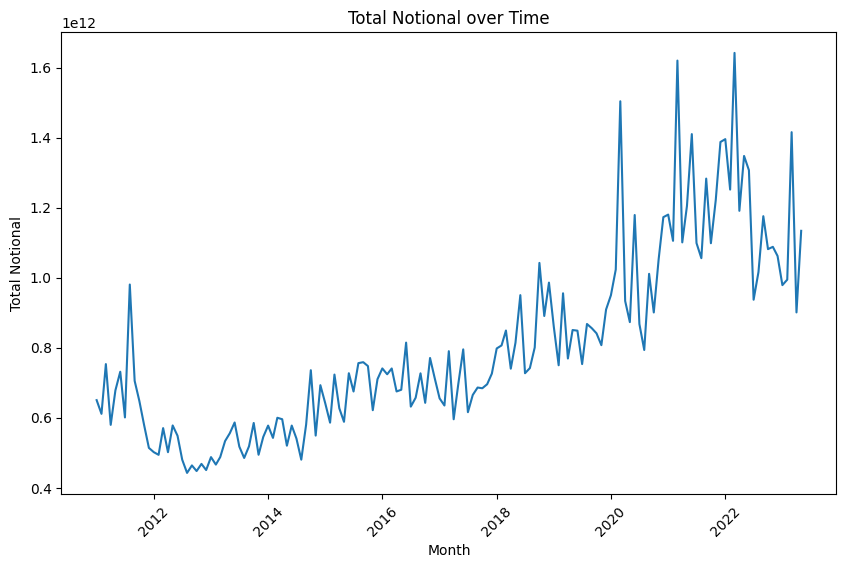

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(nyse_n_df["Month"], nyse_n_df["Total Notional"])
plt.title("Total Notional over Time")
plt.xlabel("Month")
plt.ylabel("Total Notional")
plt.xticks(rotation=45)
plt.show()

In [31]:
#Saving data
nyse_n_df.to_excel("nyse_n_data.xlsx", index=False)
files.download("/content/nyse_n_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
#Apply Dickey-Fuller test for non-stationarity
from statsmodels.tsa.stattools import adfuller

notional_values = nyse_n_df["Total Notional"]

result = adfuller(notional_values)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

Dickey-Fuller Test Results:
ADF Statistic: -0.8474871142475856
p-value: 0.8047737462208093
Critical Values:
1%: -3.4793722137854926
5%: -2.8830370378332995
10%: -2.578233635380623


In [33]:
#Notional value is non-stationary. So, we will put in growth rates.
#put it in monthly order
nyse_n_df = nyse_n_df.sort_values("Month")

nyse_n_df["Monthly Growth"] = nyse_n_df["Total Notional"].pct_change()

print(nyse_n_df.head())

   Market Participant      Month  Total Notional  Monthly Growth
12           NYSE (N) 2011-01-01    6.497868e+11             NaN
27           NYSE (N) 2011-02-01    6.105946e+11       -0.060316
42           NYSE (N) 2011-03-01    7.527405e+11        0.232799
57           NYSE (N) 2011-04-01    5.791401e+11       -0.230625
72           NYSE (N) 2011-05-01    6.776794e+11        0.170148


In [34]:
#Droping the first obs, as it was NaN due to the change to Monthly growth
nyse_n_df = nyse_n_df.dropna(subset=["Monthly Growth"], how="any")

# Rename
nyse_n_df = nyse_n_df.rename(columns={"Monthly Growth": "Monthly Growth Dollar Value Traded", "Total Notional": "Dollar Value Traded"})

# Print the updated dataframe
print(nyse_n_df.head())

   Market Participant      Month  Dollar Value Traded  \
27           NYSE (N) 2011-02-01         6.105946e+11   
42           NYSE (N) 2011-03-01         7.527405e+11   
57           NYSE (N) 2011-04-01         5.791401e+11   
72           NYSE (N) 2011-05-01         6.776794e+11   
87           NYSE (N) 2011-06-01         7.309292e+11   

    Monthly Growth Dollar Value Traded  
27                           -0.060316  
42                            0.232799  
57                           -0.230625  
72                            0.170148  
87                            0.078577  


Dickey-Fuller Test Results:
ADF Statistic: -2.9142371442671826
p-value: 0.043717283731658285
Critical Values:
1%: -3.4793722137854926
5%: -2.8830370378332995
10%: -2.578233635380623


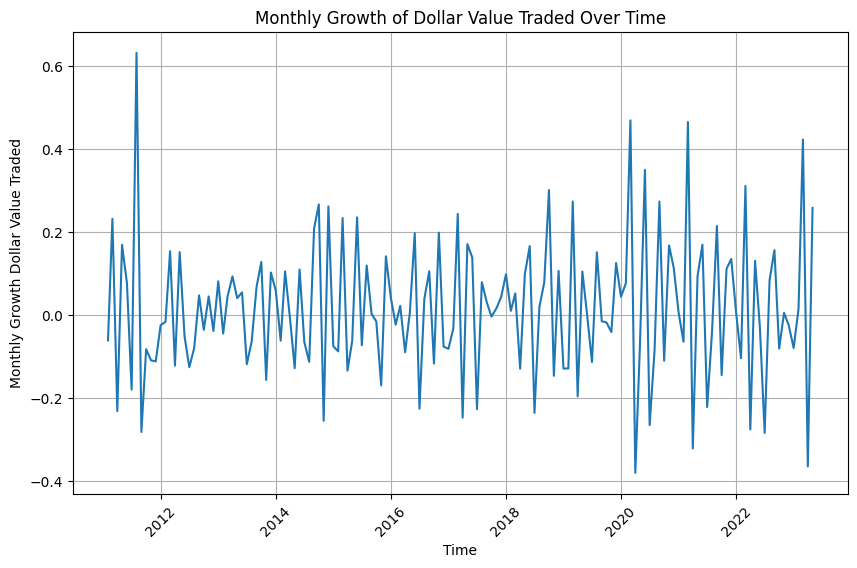

In [35]:

#Perform the Dickey-Fuller test to check if Monthly Growth Dollar Value Traded is still non-stationary
monthly_growth = nyse_n_df["Monthly Growth Dollar Value Traded"]

result = adfuller(monthly_growth)

adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print("Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"{key}: {value}")

#And plot it

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(nyse_n_df["Month"], nyse_n_df["Monthly Growth Dollar Value Traded"])
plt.xlabel("Time")
plt.ylabel("Monthly Growth Dollar Value Traded")
plt.title("Monthly Growth of Dollar Value Traded Over Time")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid lines
plt.show()

Monthly Growth Dollar Value Traded is non-stationary and will be used for the rest of the analysis.

In [36]:
#Re-download this updated dateset
nyse_n_df.to_excel("nyse_n_data.xlsx", index=False)
files.download("/content/nyse_n_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
#Load inflation data
#I already had to make this data more readable in excel before importing
file_path = '/content/Inflation modified.xlsx'
inflation_data = pd.read_excel(file_path)
print(inflation_data.head())

       Month  Inflation
0 2013-01-01        1.9
1 2013-02-01        2.0
2 2013-03-01        1.9
3 2013-04-01        1.7
4 2013-05-01        1.7


In [39]:
#merge
nyse_inflation = pd.merge(nyse_n_df, inflation_data, on="Month", how="left")
print(nyse_inflation.head())
print(nyse_inflation.tail())

  Market Participant      Month  Dollar Value Traded  \
0           NYSE (N) 2011-02-01         6.105946e+11   
1           NYSE (N) 2011-03-01         7.527405e+11   
2           NYSE (N) 2011-04-01         5.791401e+11   
3           NYSE (N) 2011-05-01         6.776794e+11   
4           NYSE (N) 2011-06-01         7.309292e+11   

   Monthly Growth Dollar Value Traded  Inflation  
0                           -0.060316        NaN  
1                            0.232799        NaN  
2                           -0.230625        NaN  
3                            0.170148        NaN  
4                            0.078577        NaN  
    Market Participant      Month  Dollar Value Traded  \
143           NYSE (N) 2023-01-01         9.782948e+11   
144           NYSE (N) 2023-02-01         9.939717e+11   
145           NYSE (N) 2023-03-01         1.415257e+12   
146           NYSE (N) 2023-04-01         9.003488e+11   
147           NYSE (N) 2023-05-01         1.133465e+12   

     Mon

Test Statistic:  0.006444163103560429
p-value:  0.9590617803263128
Critical Values:
	1%: -3.490683082754047
	5%: -2.8879516565798817
	10%: -2.5808574442009578


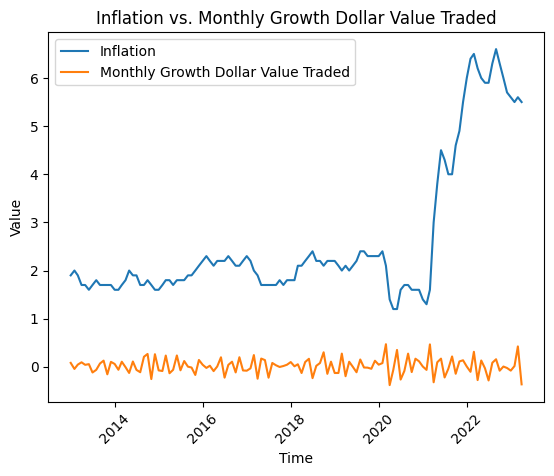

In [42]:

# taking off observations with no data for inflation
filtered_data = nyse_inflation.dropna(subset=["Inflation"])
#plot
plt.plot(filtered_data["Month"], filtered_data["Inflation"], label="Inflation")
plt.plot(filtered_data["Month"], filtered_data["Monthly Growth Dollar Value Traded"], label="Monthly Growth Dollar Value Traded")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Inflation vs. Monthly Growth Dollar Value Traded")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [43]:
#Save and download the data
nyse_n_df.to_excel("nyse_inflation.xlsx", index=False)
files.download("/content/nyse_inflation.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>